# Importation des librairies

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from scipy.signal import butter, filtfilt
import time

# Création du contexte sur le GPU

In [ ]:
cuda.init()
dev = cuda.Device(1)
contx = dev.make_context()

# Définition de la fonction créant l'allocation mémoire

In [ ]:
def Numpy_to_gpu(M):
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)
    return([M,M_gpu])

def Etat_initial_cpy(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)

    M_gpu_cpy = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu_cpy, M)
    return [M, M_gpu, M_gpu_cpy]

def Etat_initial(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)
    return [M,M_gpu]

def Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, Aff_courbe, x_courbe, z_courbe):
    fig, axs = pp.subplots(3, 2, constrained_layout=True, figsize=(10, 10))
    gridspec = axs[0, 0].get_subplotspec().get_gridspec()


    # Affichage U
    ax1 = axs[0, 0]
    Umin = np.min(U)
    Umax = np.max(U)
    mylevelsU = np.linspace(Umin, Umax, 30)
    ax1.contourf(X, Z, U, levels=mylevelsU, cmap=trace_type)
    ax1.set_title("U")
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")

    # Affichage V
    ax2 = axs[0, 1]
    Vmin = np.min(V)
    Vmax = np.max(V)
    mylevelsV = np.linspace(Vmin, Vmax, 30)
    ax2.contourf(X, Z, V, levels=mylevelsV, cmap=trace_type)
    ax2.set_title("V")
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    #   Affichage Sigma_xx
    ax3 = axs[1, 0]
    Sigma_xx_min = np.min(Sigma_xx)
    Sigma_xx_max = np.max(Sigma_xx)
    mylevels_Sigma_xx = np.linspace(Sigma_xx_min, Sigma_xx_max, 30)
    ax3.contourf(X, Z, Sigma_xx, levels=mylevels_Sigma_xx, cmap=trace_type)
    ax3.set_title("Sigma_xx")
    ax3.set_xlabel("x")
    ax3.set_ylabel("z")

    # Affichage Sigma_zz
    ax4 = axs[1, 1]
    Sigma_zz_min = np.min(Sigma_zz)
    Sigma_zz_max = np.max(Sigma_zz)
    mylevels_Sigma_zz = np.linspace(Sigma_zz_min, Sigma_zz_max, 30)
    ax4.contourf(X, Z, Sigma_zz, levels=mylevels_Sigma_zz, cmap=trace_type)
    ax4.set_title("Sigma_zz")
    ax4.set_xlabel("x")
    ax4.set_ylabel("z")

    # Affichage Sigma_xz
    ax5 = axs[2, 0]
    Sigma_xz_min = np.min(Sigma_xz)
    Sigma_xz_max = np.max(Sigma_xz)
    mylevels_Sigma_xz = np.linspace(Sigma_xz_min, Sigma_xz_max, 30)
    ax5.contourf(X, Z, Sigma_xz, levels=mylevels_Sigma_xz, cmap=trace_type)
    ax5.set_title("Sigma_xz")
    ax5.set_xlabel("x")
    ax5.set_ylabel("z")
    if Aff_courbe==True:
        ax1.plot(x_surface,z_surface,'k')
        ax2.plot(x_surface,z_surface,'k')
        ax3.plot(x_surface,z_surface,'k')
        ax4.plot(x_surface,z_surface,'k')
        ax5.plot(x_surface,z_surface,'k')
    pp.show()
    
def Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu,longueur_grille_x):
    mod_def_mirror_point = SourceModule("""

    __global__ void Calcul_point_miroir(float *coor_miroir, float *z_fantome, float *z_surface,float *x_fantome,float *x_surface)
    {
        int idx = (threadIdx.x+1+blockIdx.x*blockDim.x);
        int i=-10;
        float min_dist = (x_fantome[idx]-x_surface[10*idx-10])*(x_fantome[idx]-x_surface[10*idx-10])+
        (z_fantome[idx]-z_surface[10*idx-10])*(z_fantome[idx]-z_surface[10*idx-10]);
        int i_min=-10;
        for (i=-10;i<10;i++) 
        {
            if ((x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
            (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i])<min_dist)
            {
                min_dist=(x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
                (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i]);
                i_min=i;
            }
        }
        coor_miroir[2*idx]=2*x_surface[10*idx+i_min]-x_fantome[idx];
        coor_miroir[2*idx+1]=2*z_surface[10*idx+i_min]-z_fantome[idx];
    }""")
    Calcul_point_miroir = mod_def_mirror_point.get_function("Calcul_point_miroir")
    Calcul_point_miroir(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, block=(32, 1, 1), grid=(longueur_grille_x, 1))


def Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu,
                  Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
                  longueur_grille_z, source_t, Methode_calcul_mirror):
    
    velocity_to_stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                   dz, source_t, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    
    if (Methode_calcul_mirror == True) :
        Mirror_iteration(Sigma_xx, Sigma_xx_gpu, Sigma_xx_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(Sigma_xz, Sigma_xz_gpu, Sigma_xz_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(Sigma_zz, Sigma_zz_gpu, Sigma_zz_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)

def Mirror_iteration(M, M_gpu, M_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz):

    mod_mirror_iteration =SourceModule("""
        __global__ void Mise_a_zero_miroir_velocity (float *p, int *coor_fantome_z)
        {
            if(threadIdx.y+blockDim.y *blockIdx.y+1>coor_fantome_z[threadIdx.x+blockDim.x *blockIdx.x+1]-1)
            {
                p[threadIdx.x+1+blockDim.x *blockIdx.x+(threadIdx.y+1+blockDim.y *blockIdx.y)*(blockDim.x *gridDim.x+2)]=0;
            }

        }
        __global__ void Iteration_miroir_velocity (float *p, float *p_cpy, int *coor_fantome_z,float *coef_interpolation,int Nz)
        {
            int idx=(threadIdx.x+1) +(blockIdx.x*blockDim.x);
            float pvalue=0;
            int i=0;
            int j=0;
            for(i=1;i<blockDim.x *gridDim.x;i++)
            {
                for (j=1;j<Nz;j++)
                {
                    pvalue+=p_cpy[i+j*(blockDim.x *gridDim.x+2)]*coef_interpolation[(blockDim.x *gridDim.x+2)*(j+idx*(blockDim.y *gridDim.y+2))+i];
                }
            }
            p[idx+coor_fantome_z[idx]*(blockDim.x *gridDim.x+2)]=-pvalue; 
        }
        """)
    
    Mise_a_zero_miroir_velocity=mod_mirror_iteration.get_function("Mise_a_zero_miroir_velocity")
    Iteration_miroir=mod_mirror_iteration.get_function("Iteration_miroir_velocity")
    
    Mise_a_zero_miroir_velocity(M_gpu, Coor_point_fantome_gpu, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    for i in [1, 20]:
            Iteration_miroir(M_gpu, M_gpu_cpy, Coor_point_fantome_gpu, Coef_interpolation, Nz, block=(32, 1, 1), grid=(longueur_grille_x, 1))
            cuda.memcpy_dtod(M_gpu_cpy, M_gpu, M.nbytes)

def Calcul_velocity(U_gpu, U_gpu_cpy, V_gpu, V_gpu_cpy, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz,
                    longueur_grille_x, longueur_grille_z, Methode_calcul_mirror):
    
    stress_to_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, block=(32, 32, 1),
                       grid=(longueur_grille_x, longueur_grille_z))
    if (Methode_calcul_mirror == True) :
        Mirror_iteration(U, U_gpu, U_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(V, V_gpu, V_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)

def filtre_surface(data,cutoff,fs,order):
    normal_cutoff=2*cutoff/fs
    b,a=butter(order,normal_cutoff,btype=('low'),analog=False)
    y=filtfilt(b,a,data)
    return(y)

def Fonction_Source(t,alpĥa, retard):
    result=-2*alpha*(1-2*alpha*(t-retard)**2)* np.exp(-alpha*(t-retard)**2)
    return(result.astype(np.float32))

# def Calcul_propagation(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu,
#                        dt, dx, dz,longueur_grille_x, longueur_grille_z, Methode_calcul_mirror, trace_type, Nt, 
#                        nb_iter_aff):

#     # Définition des paramétres d'itération en temps
#     nt = 0
#     t = np.float32(0)
    
#     Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
#                        dz, t,longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)

#     start=time.time()
#     while nt < Nt:

#         Calcul_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz,
#                         longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)
#         # Calcul des contraintes sur toute la matrice
#         Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
#                        dz, t,longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)

#         # Itération en temps
#         nt += 1
#         t += dt

#         # Affichage en python
#         if nt % nb_iter_aff == 0:
#             end=time.time()
#             print(end-start)
#             start=time.time()
#             # On importe les résultats Cuda en python
#             cuda.memcpy_dtoh(U, U_gpu)
#             cuda.memcpy_dtoh(V, V_gpu)
#             cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
#             cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
#             cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)

#             Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, True, x_surface, 
#                                  z_surface)

#             end=time.time()
#             print(end-start)
#             start=time.time()

def Creating_ghost_point(z_surface, z_min, dz, Nx):
    z_fantome=[]
    for i in range (Nx):
        z_fantome.append((int((z_surface[10*i]+z_min)/dz)+1)*dz-z_min)
    z_fantome =np.array(z_fantome)
    [z_fantome,z_fantome_gpu] = Numpy_to_gpu(z_fantome)
    
    Coor_point_fantome = (z_fantome-z_min)/dz
    Coor_point_fantome = Coor_point_fantome.astype(np.int32)
    Coor_point_fantome_gpu = cuda.mem_alloc(Coor_point_fantome.nbytes)
    cuda.memcpy_htod(Coor_point_fantome_gpu, Coor_point_fantome)
    
    return([z_fantome,z_fantome_gpu,Coor_point_fantome_gpu])

def Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, z_min, dz):

    Coor_miroir = np.zeros((Nx , 2))
    [Coor_miroir,Coor_miroir_gpu] = Numpy_to_gpu(Coor_miroir)
    
    Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, (Nx-2)//32)
    
    return([Coor_miroir, Coor_miroir_gpu])

def Treating_data_surface(x_min, x_max, Nx, x_data, z_data):
    
    Nx_courbe = 10 * (Nx - 1) + 1
    dx_courbe = np.float32((x_max - x_min) / (Nx_courbe - 1))

    x_surface=np.linspace(x_min,x_max,Nx_courbe)
    [x_surface,x_surface_gpu]=Numpy_to_gpu(x_surface)
    
    x_data_min=np.min(x_data)
    x_data_max=np.max(x_data)
    
    if (x_min>x_data_min) or (x_max < x_data_max):
        print("Les données ne permettent pas de créer la surface sur l'ensemble du domaine d'étude.")
    
    z_surface =np.interp(x_surface, x_data, z_data)
    z_surface=filtre_surface(z_surface, 1/dx, 1/dx_courbe, 4)
    [z_surface,z_surface_gpu]=Numpy_to_gpu(z_surface)
    
    return([x_surface, x_surface_gpu, z_surface, z_surface_gpu])

def Create_surface(x_min, x_max, Nx, x_data, z_data, x, x_gpu, dz):
    
    [x_surface, x_surface_gpu, z_surface, z_surface_gpu]=Treating_data_surface(x_min, x_max, Nx, x_data, z_data)
    
    [z_fantome,z_fantome_gpu,Coor_point_fantome_gpu] = Creating_ghost_point(z_surface, z_min, dz, Nx)
    
    [Coor_miroir, Coor_miroir_gpu]=Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, z_min, dz)
    
    cuda.memcpy_dtoh(Coor_miroir, Coor_miroir_gpu)
    
    pp.figure(figsize=(15, 15))
    pp.plot(x_surface,z_surface)
    pp.plot(x,z_fantome)
    pp.plot(Coor_miroir[1:-1,0],Coor_miroir[1:-1,1])
    pp.show
    return([Coor_point_fantome_gpu,Coor_miroir_gpu])
    
    
    
# def Initial_state(x_min, x_max, z_min, z_max, Tf, Nx, Nz, Coor_source, x_data_surface, z_data_surface):
#     # Teste si Nz et Nx sont sous la bonne forme pour les GPU
#     if (Nx - 2) % 32 != 0:
#         Nx += 32 - (Nx - 2) % 32
#     if (Nz - 2) % 32 != 0:
#         Nz += 32 - (Nz - 2) % 32

#     dz = np.float32((z_max - z_min) / (Nz - 1))
#     dx = np.float32((x_max - x_min) / (Nx - 1))
#     [U,U_gpu,U_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [V,V_gpu,V_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [Sigma_xx,Sigma_xx_gpu,Sigma_xx_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [Sigma_xz,Sigma_xz_gpu,Sigma_xz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#         [Sigma_zz,Sigma_zz_gpu,Sigma_zz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     # Teste si Nz et Nx sont sous la bonne forme pour les GPU
#     if (Nx - 2) % 32 != 0:
#         Nx += 32 - (Nx - 2) % 32
#     if (Nz - 2) % 32 != 0:
#         Nz += 32 - (Nz - 2) % 32

#     dz = np.float32((z_max - z_min) / (Nz - 1))
#     dx = np.float32((x_max - x_min) / (Nx - 1))

#     # Creating dataset
#     X, Z = np.meshgrid(np.linspace(x_min, x_max, Nx), np.linspace(z_min, z_max, Nz))
    
#     # Create coordinate point source
#     Coor_point_source=[np.int32(int((Coor_source[0] - x_min) / dx)),np.int32(int((Coor_source[1] - z_min) / dz))]
    
#     # Create coordinate point source
#     [x_surface,x_surface_gpu,z_surface,z_surface_gpu] = Treating_data_surface(x_min, x_max, Nx, x_data, z_data)


# Définition du domaine d'étude et des pas de discrétisation spatial

In [ ]:
# Définition du domaine d'étude
x_min = -5000
x_max = 5000
z_min = -5000
z_max = 5000

Tf = 5

alpha=2000

t0=0.3

Nz = 200
Nx = 200

# Teste si Nz et Nx sont sous la bonne forme pour les GPU
if (Nx - 2) % 32 != 0:
    Nx += 32 - (Nx - 2) % 32
if (Nz - 2) % 32 != 0:
    Nz += 32 - (Nz - 2) % 32

dz = np.float32((z_max - z_min) / (Nz - 1))
dx = np.float32((x_max - x_min) / (Nx - 1))

# Creating dataset
X, Z = np.meshgrid(np.linspace(x_min, x_max, Nx), np.linspace(z_min, z_max, Nz))

x = X[0, :]
[x,x_gpu]=Numpy_to_gpu(x)


 # Positionnement de la source sur le maillage

In [ ]:
x_source = 0
z_source = 0
i_source = np.int32(int((x_source - x_min) / dx))
j_source = np.int32(int((z_source - z_min) / dz))
coor_source =np.int32(i_source +j_source * Nx)

# Code en Cuda

In [ ]:
mod = SourceModule("""
#include <math.h>
#define NX (blockDim.x*gridDim.x+2)

__device__ float Df(float xn1,float xn, float dx)
{
    return((xn1-xn)/dx);
}
__global__ void stress_to_velocity(float *u, float *v, float *b, float *sigma_xx,
float *sigma_zz, float *sigma_xz, float dt, float dx, float dz)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ 
    (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    
    u[idx] += b[2*idx]*dt*(Df(sigma_xx[idx],sigma_xx[idx-1],dx)+
    Df(sigma_xz[idx],sigma_xz[idx-NX],dz));
    
    v[idx] += b[2*idx+1]*dt*(Df(sigma_xz[idx+1],sigma_xz[idx],dx)+
    Df(sigma_zz[idx + NX],sigma_zz[idx],dz));
}
__global__ void velocity_to_stress(float *u, float *v, float *l, float *m, int coor_source, float *sigma_xx,
float *sigma_zz, float *sigma_xz,float dt,float dx, float dz, float source_t)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    
    sigma_xx[idx] += (l[idx]+2*m[2*idx+1])*dt*Df(u[idx+1],u[idx],dx)+
    l[idx]*dt*Df(v[idx],v[idx-NX],dz);
    
    sigma_zz[idx] += (l[idx]+2*m[2*idx+1])*dt*Df(v[idx],v[idx-NX],dz)+
    l[idx]*dt*Df(u[idx+1],u[idx],dx);
    
    sigma_xz[idx] += (m[2*idx+1])*dt*(Df(v[idx],v[idx-1],dx)+
    Df(u[idx+NX],u[idx],dz));
    
    if (idx == coor_source)
    {
        sigma_xx[idx] += source_t;
        sigma_zz[idx] += source_t;;
    }
}
__global__ void Mise_a_zero_miroir_velocity (float *p, int *coor_fantome_z)
{
    if(threadIdx.y+blockDim.y *blockIdx.y+1>coor_fantome_z[threadIdx.x+blockDim.x *blockIdx.x+1]-1)
    {
        p[threadIdx.x+1+blockDim.x *blockIdx.x+(threadIdx.y+1+blockDim.y *blockIdx.y) * NX]=0;
    }

}
__device__ float sinc(float x)
{
    if (x==0)
    {return(1);}
    else
    {return(sin(M_PI*x)/(M_PI*x));}
}
__global__ void Calcul_coefficient_interpolation(float *coef_interpolation, float *coor_miroir,float dx, float dz,
float x_min,float z_min)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    int i=0;
    int m= threadIdx.x+1 +blockIdx.x*blockDim.x;
    int n= threadIdx.y + 1 + blockDim.y * blockIdx.y;
    float Bx=1/(2*dx);
    float Bz=1/(2*dz);
    float rx=2*Bx*dx;
    float ry=2*Bz*dz;
    int Nz=(blockDim.y *gridDim.y+2);
    for (i=1;i<(blockDim.x *gridDim.x+1);i++)
    {
        coef_interpolation[idx+i*NX*Nz]=rx*ry*sinc(2*Bx*(coor_miroir[2*i]-x_min)-rx*m)*sinc(2*Bz*(coor_miroir[2*i+1]-z_min)-ry*n);
    }
}

""")

# Discrétisation de la topographie

In [ ]:
# Definition des points de la courbe
Nx_data = 20* (Nx - 1) + 1
dx_data = np.float32((x_max - x_min) / (Nx_data - 1))
x_data=np.linspace(x_min,x_max,Nx_data)
z_data = 4000 * np.exp(-np.square(x_data) / (1000) ** 2)

[x_surface,x_surface_gpu,z_surface,z_surface_gpu]=Treating_data_surface(x_min, x_max, Nx, x_data, z_data)

# Préparation des allocations mémoires pour les points miroirs et définition des points fantome 

In [ ]:
z_fantome=[]
for i in range (Nx):
    z_fantome.append((int((z_surface[10*i]+z_min)/dz)+1)*dz-z_min)
z_fantome =np.array(z_fantome)
[z_fantome,z_fantome_gpu] = Numpy_to_gpu(z_fantome)

Coor_miroir = np.zeros((Nx , 2))
[Coor_miroir,Coor_miroir_gpu] = Numpy_to_gpu(Coor_miroir)

Coor_point_fantome = (z_fantome-z_min)/dz
Coor_point_fantome = Coor_point_fantome.astype(np.int32)
Coor_point_fantome_gpu = cuda.mem_alloc(Coor_point_fantome.nbytes)
cuda.memcpy_htod(Coor_point_fantome_gpu, Coor_point_fantome)

# Préparation des allocations mémoires pour l'état initial

In [ ]:
[U,U_gpu,U_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[V,V_gpu,V_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_xx,Sigma_xx_gpu,Sigma_xx_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_xz,Sigma_xz_gpu,Sigma_xz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_zz,Sigma_zz_gpu,Sigma_zz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

# Préparation des allocations mémoires pour les propriété du sol en tout point

In [ ]:
Vp = 3000  # Vitesse des ondes P
Vs = 1500  # Vitesse des ondes S
rho = 2000  # Densité

B = np.ones((Nz, 2 * Nx)) / rho  # Inverse de la densité (i,i+1/2,j,j+1/2)
[B,B_gpu]=Numpy_to_gpu(B)

L = (rho * Vp ** 2 - 2 * rho * Vs ** 2) * np.ones((Nz, Nx))  # Coefficient Lambda (i+1/2,j)
[L,L_gpu]=Numpy_to_gpu(L)
print((rho * Vp ** 2 - 2 * rho * Vs ** 2))

M = (rho * Vs ** 2) * np.ones((Nz, 2*Nx))  # Coefficient Mu (i,i+1/2,j,j+1/2)
[M,M_gpu]=Numpy_to_gpu(M)
print((rho * Vs ** 2))

# Définition du pas de temps

In [ ]:
dt = np.float32(0.8* dx /(np.sqrt(2)*Vp))
Nt = int(Tf / dt) + 1
print(Nt)

# Importation des fonctions et définition des tailles de la grille

In [ ]:
# Importation des fonctions cuda
Calcul_coefficient_interpolation=mod.get_function("Calcul_coefficient_interpolation")
stress_to_velocity = mod.get_function("stress_to_velocity")
velocity_to_stress = mod.get_function("velocity_to_stress")

longueur_grille_x = (Nx - 2) // 32
longueur_grille_z = (Nz - 2) // 32
x_min=np.float32(x_min)
z_min=np.float32(z_min)
Nz=np.int32(Nz)

# Test fonction V->Sigma


In [ ]:

# # U=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # U=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # U=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # U=np.array(U)
# # [U,U_gpu]=Numpy_to_gpu(U)

# [U,U_gpu]=Etat_initial(4,4)

# [V,V_gpu]=Etat_initial(4,4)
# # V=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # V=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # V=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # V=np.array(V)
# # [V,V_gpu]=Numpy_to_gpu(V)

# [Sigma_xx,Sigma_xx_gpu]=Etat_initial(4,4)
# # Sigma_xx=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_xx=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_xx=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # Sigma_xx=np.array(Sigma_xx)
# # [Sigma_xx,Sigma_xx_gpu]=Numpy_to_gpu(Sigma_xx)


# [Sigma_xz,Sigma_xz_gpu]=Etat_initial(4,4)
# # Sigma_xz=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_xz=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_xz=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # Sigma_xz=np.array(Sigma_xz)
# # [Sigma_xz,Sigma_xz_gpu]=Numpy_to_gpu(Sigma_xz)


# # [Sigma_zz,Sigma_zz_gpu]=Etat_initial(4,4)
# Sigma_zz=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_zz=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_zz=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# Sigma_zz=np.array(Sigma_zz)
# [Sigma_zz,Sigma_zz_gpu]=Numpy_to_gpu(Sigma_zz)

# dt=np.float32(1)
# dx=np.float32(1)
# dz=np.float32(1)
# t=np.float32(0)

# B = np.ones((2 * 4, 4))
# [B,B_gpu]=Numpy_to_gpu(B)

# L =np.ones((4, 4))  
# [L,L_gpu]=Numpy_to_gpu(L)

# M =np.ones((2 * 4, 4))  
# [M,M_gpu]=Numpy_to_gpu(M)

# # velocity_to_stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, 
# #                    Sigma_xz_gpu, dt, dx, dz, t, block=(2, 2, 1), grid=(1,1))
# stress_to_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, 
#                    block=(1, 1, 1), grid=(2, 1))

# cuda.memcpy_dtoh(U, U_gpu)
# cuda.memcpy_dtoh(V, V_gpu)
# cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
# cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
# cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)

# # print(Sigma_xx)
# print(Sigma_zz)
# # print(Sigma_xz)
# print(U)
# print(V)

# Calcul des points miroirs

In [ ]:
Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu,longueur_grille_x)

Coef_interpolation=cuda.mem_alloc(Nx*U.nbytes)
Calcul_coefficient_interpolation(Coef_interpolation, Coor_miroir_gpu,dx,dz,x_min,z_min, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))

pp.figure(figsize=(15, 15))
pp.plot(x_surface,z_surface)
pp.plot(x,z_fantome)
cuda.memcpy_dtoh(Coor_miroir, Coor_miroir_gpu)
pp.plot(Coor_miroir[1:-1,0],Coor_miroir[1:-1,1])
pp.show

# Calcul de la propagation et Affichage de la propagation

In [ ]:
Methode_calcul_mirror = True
trace_type="coolwarm"
nb_iter_aff=100
vecteur_source=[]

# Définition des paramétres d'itération en temps
nt = 0
t = np.float32(0)

source_t=Fonction_Source(t,alpha,t0)
Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu, 
              Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
              longueur_grille_z, source_t, Methode_calcul_mirror)
vecteur_source.append(source_t)
while nt < Nt:
# Itération en temps
    nt += 1
    t += dt
    
    source_t=Fonction_Source(t,alpha,t0)
    Calcul_velocity(U_gpu, U_gpu_cpy, V_gpu, V_gpu_cpy, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                    dz, longueur_grille_x, longueur_grille_z, Methode_calcul_mirror)
    
    
    # Calcul des contraintes sur toute la matrice
    Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu, 
                  Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
                  longueur_grille_z, source_t, Methode_calcul_mirror)
    vecteur_source.append(source_t)
    
    # Affichage en python
    if nt % nb_iter_aff == 0:        
        # On importe les résultats Cuda en python
        cuda.memcpy_dtoh(U, U_gpu)
        cuda.memcpy_dtoh(V, V_gpu)
        cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
        cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
        cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)
        
        Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, True, x_surface, z_surface)


# Suppression du contexte

In [ ]:
contx.pop()

In [ ]:
pp.plot(vecteur_source)


In [1]:
import numpy as np
import matplotlib.pyplot as pp
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from scipy.signal import butter, filtfilt
import time

# Création du contexte sur le GPU

In [2]:
cuda.init()
dev = cuda.Device(1)
contx = dev.make_context()

# Définition de la fonction créant l'allocation mémoire

In [3]:
def Numpy_to_gpu(M):
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)
    return([M,M_gpu])

def Etat_initial_cpy(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)

    M_gpu_cpy = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu_cpy, M)
    return [M, M_gpu, M_gpu_cpy]

def Etat_initial(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)
    return [M,M_gpu]

def Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, Aff_courbe, x_courbe, z_courbe):
    fig, axs = pp.subplots(3, 2, constrained_layout=True, figsize=(10, 10))
    gridspec = axs[0, 0].get_subplotspec().get_gridspec()


    # Affichage U
    ax1 = axs[0, 0]
    Umin = np.min(U)
    Umax = np.max(U)
    mylevelsU = np.linspace(Umin, Umax, 30)
    ax1.contourf(X, Z, U, levels=mylevelsU, cmap=trace_type)
    ax1.set_title("U")
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")

    # Affichage V
    ax2 = axs[0, 1]
    Vmin = np.min(V)
    Vmax = np.max(V)
    mylevelsV = np.linspace(Vmin, Vmax, 30)
    ax2.contourf(X, Z, V, levels=mylevelsV, cmap=trace_type)
    ax2.set_title("V")
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    #   Affichage Sigma_xx
    ax3 = axs[1, 0]
    Sigma_xx_min = np.min(Sigma_xx)
    Sigma_xx_max = np.max(Sigma_xx)
    mylevels_Sigma_xx = np.linspace(Sigma_xx_min, Sigma_xx_max, 30)
    ax3.contourf(X, Z, Sigma_xx, levels=mylevels_Sigma_xx, cmap=trace_type)
    ax3.set_title("Sigma_xx")
    ax3.set_xlabel("x")
    ax3.set_ylabel("z")

    # Affichage Sigma_zz
    ax4 = axs[1, 1]
    Sigma_zz_min = np.min(Sigma_zz)
    Sigma_zz_max = np.max(Sigma_zz)
    mylevels_Sigma_zz = np.linspace(Sigma_zz_min, Sigma_zz_max, 30)
    ax4.contourf(X, Z, Sigma_zz, levels=mylevels_Sigma_zz, cmap=trace_type)
    ax4.set_title("Sigma_zz")
    ax4.set_xlabel("x")
    ax4.set_ylabel("z")

    # Affichage Sigma_xz
    ax5 = axs[2, 0]
    Sigma_xz_min = np.min(Sigma_xz)
    Sigma_xz_max = np.max(Sigma_xz)
    mylevels_Sigma_xz = np.linspace(Sigma_xz_min, Sigma_xz_max, 30)
    ax5.contourf(X, Z, Sigma_xz, levels=mylevels_Sigma_xz, cmap=trace_type)
    ax5.set_title("Sigma_xz")
    ax5.set_xlabel("x")
    ax5.set_ylabel("z")
    if Aff_courbe==True:
        ax1.plot(x_surface,z_surface,'k')
        ax2.plot(x_surface,z_surface,'k')
        ax3.plot(x_surface,z_surface,'k')
        ax4.plot(x_surface,z_surface,'k')
        ax5.plot(x_surface,z_surface,'k')
    pp.show()
    
def Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu,longueur_grille_x):
    mod_def_mirror_point = SourceModule("""

    __global__ void Calcul_point_miroir(float *coor_miroir, float *z_fantome, float *z_surface,float *x_fantome,float *x_surface)
    {
        int idx = (threadIdx.x+1+blockIdx.x*blockDim.x);
        int i=-10;
        float min_dist = (x_fantome[idx]-x_surface[10*idx-10])*(x_fantome[idx]-x_surface[10*idx-10])+
        (z_fantome[idx]-z_surface[10*idx-10])*(z_fantome[idx]-z_surface[10*idx-10]);
        int i_min=-10;
        for (i=-10;i<10;i++) 
        {
            if ((x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
            (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i])<min_dist)
            {
                min_dist=(x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
                (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i]);
                i_min=i;
            }
        }
        coor_miroir[2*idx]=2*x_surface[10*idx+i_min]-x_fantome[idx];
        coor_miroir[2*idx+1]=2*z_surface[10*idx+i_min]-z_fantome[idx];
    }""")
    Calcul_point_miroir = mod_def_mirror_point.get_function("Calcul_point_miroir")
    Calcul_point_miroir(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, block=(32, 1, 1), grid=(longueur_grille_x, 1))


def Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu,
                  Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
                  longueur_grille_z, source_t, Methode_calcul_mirror):
    
    velocity_to_stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                   dz, source_t, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    
    if (Methode_calcul_mirror == True) :
        Mirror_iteration(Sigma_xx, Sigma_xx_gpu, Sigma_xx_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(Sigma_xz, Sigma_xz_gpu, Sigma_xz_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(Sigma_zz, Sigma_zz_gpu, Sigma_zz_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)

def Mirror_iteration(M, M_gpu, M_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz):

    mod_mirror_iteration =SourceModule("""
        __global__ void Mise_a_zero_miroir_velocity (float *p, int *coor_fantome_z)
        {
            if(threadIdx.y+blockDim.y *blockIdx.y+1>coor_fantome_z[threadIdx.x+blockDim.x *blockIdx.x+1]-1)
            {
                p[threadIdx.x+1+blockDim.x *blockIdx.x+(threadIdx.y+1+blockDim.y *blockIdx.y)*(blockDim.x *gridDim.x+2)]=0;
            }

        }
        __global__ void Iteration_miroir_velocity (float *p, float *p_cpy, int *coor_fantome_z,float *coef_interpolation,int Nz)
        {
            int idx=(threadIdx.x+1) +(blockIdx.x*blockDim.x);
            float pvalue=0;
            int i=0;
            int j=0;
            for(i=1;i<blockDim.x *gridDim.x;i++)
            {
                for (j=1;j<Nz;j++)
                {
                    pvalue+=p_cpy[i+j*(blockDim.x *gridDim.x+2)]*coef_interpolation[(blockDim.x *gridDim.x+2)*(j+idx*(blockDim.y *gridDim.y+2))+i];
                }
            }
            p[idx+coor_fantome_z[idx]*(blockDim.x *gridDim.x+2)]=-pvalue; 
        }
        """)
    
    Mise_a_zero_miroir_velocity=mod_mirror_iteration.get_function("Mise_a_zero_miroir_velocity")
    Iteration_miroir=mod_mirror_iteration.get_function("Iteration_miroir_velocity")
    
    Mise_a_zero_miroir_velocity(M_gpu, Coor_point_fantome_gpu, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    for i in [1, 20]:
            Iteration_miroir(M_gpu, M_gpu_cpy, Coor_point_fantome_gpu, Coef_interpolation, Nz, block=(32, 1, 1), grid=(longueur_grille_x, 1))
            cuda.memcpy_dtod(M_gpu_cpy, M_gpu, M.nbytes)

def Calcul_velocity(U_gpu, U_gpu_cpy, V_gpu, V_gpu_cpy, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz,
                    longueur_grille_x, longueur_grille_z, Methode_calcul_mirror):
    
    stress_to_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, block=(32, 32, 1),
                       grid=(longueur_grille_x, longueur_grille_z))
    if (Methode_calcul_mirror == True) :
        Mirror_iteration(U, U_gpu, U_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)
        Mirror_iteration(V, V_gpu, V_gpu_cpy, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz)

def filtre_surface(data,cutoff,fs,order):
    normal_cutoff=2*cutoff/fs
    b,a=butter(order,normal_cutoff,btype=('low'),analog=False)
    y=filtfilt(b,a,data)
    return(y)

def Fonction_Source(t,alpĥa, retard):
    result=-2*alpha*(1-2*alpha*(t-retard)**2)* np.exp(-alpha*(t-retard)**2)
    return(result.astype(np.float32))

# def Calcul_propagation(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu,
#                        dt, dx, dz,longueur_grille_x, longueur_grille_z, Methode_calcul_mirror, trace_type, Nt, 
#                        nb_iter_aff):

#     # Définition des paramétres d'itération en temps
#     nt = 0
#     t = np.float32(0)
    
#     Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
#                        dz, t,longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)

#     start=time.time()
#     while nt < Nt:

#         Calcul_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz,
#                         longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)
#         # Calcul des contraintes sur toute la matrice
#         Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
#                        dz, t,longueur_grille_x, longueur_grille_z,Methode_calcul_mirror)

#         # Itération en temps
#         nt += 1
#         t += dt

#         # Affichage en python
#         if nt % nb_iter_aff == 0:
#             end=time.time()
#             print(end-start)
#             start=time.time()
#             # On importe les résultats Cuda en python
#             cuda.memcpy_dtoh(U, U_gpu)
#             cuda.memcpy_dtoh(V, V_gpu)
#             cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
#             cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
#             cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)

#             Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, True, x_surface, 
#                                  z_surface)

#             end=time.time()
#             print(end-start)
#             start=time.time()

def Creating_ghost_point(z_surface, z_min, dz, Nx):
    z_fantome=[]
    for i in range (Nx):
        z_fantome.append((int((z_surface[10*i]+z_min)/dz)+1)*dz-z_min)
    z_fantome =np.array(z_fantome)
    [z_fantome,z_fantome_gpu] = Numpy_to_gpu(z_fantome)
    
    Coor_point_fantome = (z_fantome-z_min)/dz
    Coor_point_fantome = Coor_point_fantome.astype(np.int32)
    Coor_point_fantome_gpu = cuda.mem_alloc(Coor_point_fantome.nbytes)
    cuda.memcpy_htod(Coor_point_fantome_gpu, Coor_point_fantome)
    
    return([z_fantome,z_fantome_gpu,Coor_point_fantome_gpu])

def Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, z_min, dz):

    Coor_miroir = np.zeros((Nx , 2))
    [Coor_miroir,Coor_miroir_gpu] = Numpy_to_gpu(Coor_miroir)
    
    Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, (Nx-2)//32)
    
    return([Coor_miroir, Coor_miroir_gpu])

def Treating_data_surface(x_min, x_max, Nx, x_data, z_data):
    
    Nx_courbe = 10 * (Nx - 1) + 1
    dx_courbe = np.float32((x_max - x_min) / (Nx_courbe - 1))

    x_surface=np.linspace(x_min,x_max,Nx_courbe)
    [x_surface,x_surface_gpu]=Numpy_to_gpu(x_surface)
    
    x_data_min=np.min(x_data)
    x_data_max=np.max(x_data)
    
    if (x_min>x_data_min) or (x_max < x_data_max):
        print("Les données ne permettent pas de créer la surface sur l'ensemble du domaine d'étude.")
    
    z_surface =np.interp(x_surface, x_data, z_data)
    z_surface=filtre_surface(z_surface, 1/dx, 1/dx_courbe, 4)
    [z_surface,z_surface_gpu]=Numpy_to_gpu(z_surface)
    
    return([x_surface, x_surface_gpu, z_surface, z_surface_gpu])

def Create_surface(x_min, x_max, Nx, x_data, z_data, x, x_gpu, dz):
    
    [x_surface, x_surface_gpu, z_surface, z_surface_gpu]=Treating_data_surface(x_min, x_max, Nx, x_data, z_data)
    
    [z_fantome,z_fantome_gpu,Coor_point_fantome_gpu] = Creating_ghost_point(z_surface, z_min, dz, Nx)
    
    [Coor_miroir, Coor_miroir_gpu]=Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, z_min, dz)
    
    cuda.memcpy_dtoh(Coor_miroir, Coor_miroir_gpu)
    
    pp.figure(figsize=(15, 15))
    pp.plot(x_surface,z_surface)
    pp.plot(x,z_fantome)
    pp.plot(Coor_miroir[1:-1,0],Coor_miroir[1:-1,1])
    pp.show
    return([Coor_point_fantome_gpu,Coor_miroir_gpu])
    
    
    
# def Initial_state(x_min, x_max, z_min, z_max, Tf, Nx, Nz, Coor_source, x_data_surface, z_data_surface):
#     # Teste si Nz et Nx sont sous la bonne forme pour les GPU
#     if (Nx - 2) % 32 != 0:
#         Nx += 32 - (Nx - 2) % 32
#     if (Nz - 2) % 32 != 0:
#         Nz += 32 - (Nz - 2) % 32

#     dz = np.float32((z_max - z_min) / (Nz - 1))
#     dx = np.float32((x_max - x_min) / (Nx - 1))
#     [U,U_gpu,U_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [V,V_gpu,V_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [Sigma_xx,Sigma_xx_gpu,Sigma_xx_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     [Sigma_xz,Sigma_xz_gpu,Sigma_xz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#         [Sigma_zz,Sigma_zz_gpu,Sigma_zz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

#     # Teste si Nz et Nx sont sous la bonne forme pour les GPU
#     if (Nx - 2) % 32 != 0:
#         Nx += 32 - (Nx - 2) % 32
#     if (Nz - 2) % 32 != 0:
#         Nz += 32 - (Nz - 2) % 32

#     dz = np.float32((z_max - z_min) / (Nz - 1))
#     dx = np.float32((x_max - x_min) / (Nx - 1))

#     # Creating dataset
#     X, Z = np.meshgrid(np.linspace(x_min, x_max, Nx), np.linspace(z_min, z_max, Nz))
    
#     # Create coordinate point source
#     Coor_point_source=[np.int32(int((Coor_source[0] - x_min) / dx)),np.int32(int((Coor_source[1] - z_min) / dz))]
    
#     # Create coordinate point source
#     [x_surface,x_surface_gpu,z_surface,z_surface_gpu] = Treating_data_surface(x_min, x_max, Nx, x_data, z_data)


# Définition du domaine d'étude et des pas de discrétisation spatial

In [4]:
# Définition du domaine d'étude
x_min = -5000
x_max = 5000
z_min = -5000
z_max = 5000

Tf = 5

alpha=2000

t0=0.3

Nz = 200
Nx = 200

# Teste si Nz et Nx sont sous la bonne forme pour les GPU
if (Nx - 2) % 32 != 0:
    Nx += 32 - (Nx - 2) % 32
if (Nz - 2) % 32 != 0:
    Nz += 32 - (Nz - 2) % 32

dz = np.float32((z_max - z_min) / (Nz - 1))
dx = np.float32((x_max - x_min) / (Nx - 1))

# Creating dataset
X, Z = np.meshgrid(np.linspace(x_min, x_max, Nx), np.linspace(z_min, z_max, Nz))

x = X[0, :]
[x,x_gpu]=Numpy_to_gpu(x)


 # Positionnement de la source sur le maillage

In [5]:
x_source = 0
z_source = 0
i_source = np.int32(int((x_source - x_min) / dx))
j_source = np.int32(int((z_source - z_min) / dz))
coor_source =np.int32(i_source +j_source * Nx)

# Code en Cuda

In [6]:
mod = SourceModule("""
#include <math.h>
#define NX (blockDim.x*gridDim.x+2)

__device__ float Df(float xn1,float xn, float dx)
{
    return((xn1-xn)/dx);
}
__global__ void stress_to_velocity(float *u, float *v, float *b, float *sigma_xx,
float *sigma_zz, float *sigma_xz, float dt, float dx, float dz)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ 
    (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    
    u[idx] += b[2*idx]*dt*(Df(sigma_xx[idx],sigma_xx[idx-1],dx)+
    Df(sigma_xz[idx],sigma_xz[idx-NX],dz));
    
    v[idx] += b[2*idx+1]*dt*(Df(sigma_xz[idx+1],sigma_xz[idx],dx)+
    Df(sigma_zz[idx + NX],sigma_zz[idx],dz));
}
__global__ void velocity_to_stress(float *u, float *v, float *l, float *m, int coor_source, float *sigma_xx,
float *sigma_zz, float *sigma_xz,float dt,float dx, float dz, float source_t)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    
    sigma_xx[idx] += (l[idx]+2*m[2*idx+1])*dt*Df(u[idx+1],u[idx],dx)+
    l[idx]*dt*Df(v[idx],v[idx-NX],dz);
    
    sigma_zz[idx] += (l[idx]+2*m[2*idx+1])*dt*Df(v[idx],v[idx-NX],dz)+
    l[idx]*dt*Df(u[idx+1],u[idx],dx);
    
    sigma_xz[idx] += (m[2*idx+1])*dt*(Df(v[idx],v[idx-1],dx)+
    Df(u[idx+NX],u[idx],dz));
    
    if (idx == coor_source)
    {
        sigma_xx[idx] += source_t;
        sigma_zz[idx] += source_t;;
    }
}
__global__ void Mise_a_zero_miroir_velocity (float *p, int *coor_fantome_z)
{
    if(threadIdx.y+blockDim.y *blockIdx.y+1>coor_fantome_z[threadIdx.x+blockDim.x *blockIdx.x+1]-1)
    {
        p[threadIdx.x+1+blockDim.x *blockIdx.x+(threadIdx.y+1+blockDim.y *blockIdx.y) * NX]=0;
    }

}
__device__ float sinc(float x)
{
    if (x==0)
    {return(1);}
    else
    {return(sin(M_PI*x)/(M_PI*x));}
}
__global__ void Calcul_coefficient_interpolation(float *coef_interpolation, float *coor_miroir,float dx, float dz,
float x_min,float z_min)
{ 
    int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
    int i=0;
    int m= threadIdx.x+1 +blockIdx.x*blockDim.x;
    int n= threadIdx.y + 1 + blockDim.y * blockIdx.y;
    float Bx=1/(2*dx);
    float Bz=1/(2*dz);
    float rx=2*Bx*dx;
    float ry=2*Bz*dz;
    int Nz=(blockDim.y *gridDim.y+2);
    for (i=1;i<(blockDim.x *gridDim.x+1);i++)
    {
        coef_interpolation[idx+i*NX*Nz]=rx*ry*sinc(2*Bx*(coor_miroir[2*i]-x_min)-rx*m)*sinc(2*Bz*(coor_miroir[2*i+1]-z_min)-ry*n);
    }
}

""")

# Discrétisation de la topographie

In [7]:
# Definition des points de la courbe
Nx_data = 20* (Nx - 1) + 1
dx_data = np.float32((x_max - x_min) / (Nx_data - 1))
x_data=np.linspace(x_min,x_max,Nx_data)
z_data = 4000 * np.exp(-np.square(x_data) / (1000) ** 2)

[x_surface,x_surface_gpu,z_surface,z_surface_gpu]=Treating_data_surface(x_min, x_max, Nx, x_data, z_data)

# Préparation des allocations mémoires pour les points miroirs et définition des points fantome 

In [8]:
z_fantome=[]
for i in range (Nx):
    z_fantome.append((int((z_surface[10*i]+z_min)/dz)+1)*dz-z_min)
z_fantome =np.array(z_fantome)
[z_fantome,z_fantome_gpu] = Numpy_to_gpu(z_fantome)

Coor_miroir = np.zeros((Nx , 2))
[Coor_miroir,Coor_miroir_gpu] = Numpy_to_gpu(Coor_miroir)

Coor_point_fantome = (z_fantome-z_min)/dz
Coor_point_fantome = Coor_point_fantome.astype(np.int32)
Coor_point_fantome_gpu = cuda.mem_alloc(Coor_point_fantome.nbytes)
cuda.memcpy_htod(Coor_point_fantome_gpu, Coor_point_fantome)

# Préparation des allocations mémoires pour l'état initial

In [9]:
[U,U_gpu,U_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[V,V_gpu,V_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_xx,Sigma_xx_gpu,Sigma_xx_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_xz,Sigma_xz_gpu,Sigma_xz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

[Sigma_zz,Sigma_zz_gpu,Sigma_zz_gpu_cpy]=Etat_initial_cpy(Nx,Nz)

# Préparation des allocations mémoires pour les propriété du sol en tout point

In [10]:
Vp = 3000  # Vitesse des ondes P
Vs = 1500  # Vitesse des ondes S
rho = 2000  # Densité

B = np.ones((Nz, 2 * Nx)) / rho  # Inverse de la densité (i,i+1/2,j,j+1/2)
[B,B_gpu]=Numpy_to_gpu(B)

L = (rho * Vp ** 2 - 2 * rho * Vs ** 2) * np.ones((Nz, Nx))  # Coefficient Lambda (i+1/2,j)
[L,L_gpu]=Numpy_to_gpu(L)
print((rho * Vp ** 2 - 2 * rho * Vs ** 2))

M = (rho * Vs ** 2) * np.ones((Nz, 2*Nx))  # Coefficient Mu (i,i+1/2,j,j+1/2)
[M,M_gpu]=Numpy_to_gpu(M)
print((rho * Vs ** 2))

9000000000
4500000000


# Définition du pas de temps

In [11]:
dt = np.float32(0.8* dx /(np.sqrt(2)*Vp))
Nt = int(Tf / dt) + 1
print(Nt)

597


# Importation des fonctions et définition des tailles de la grille

In [12]:
# Importation des fonctions cuda
Calcul_coefficient_interpolation=mod.get_function("Calcul_coefficient_interpolation")
stress_to_velocity = mod.get_function("stress_to_velocity")
velocity_to_stress = mod.get_function("velocity_to_stress")

longueur_grille_x = (Nx - 2) // 32
longueur_grille_z = (Nz - 2) // 32
x_min=np.float32(x_min)
z_min=np.float32(z_min)
Nz=np.int32(Nz)

# Test fonction V->Sigma


In [13]:

# # U=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # U=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # U=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # U=np.array(U)
# # [U,U_gpu]=Numpy_to_gpu(U)

# [U,U_gpu]=Etat_initial(4,4)

# [V,V_gpu]=Etat_initial(4,4)
# # V=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # V=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # V=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # V=np.array(V)
# # [V,V_gpu]=Numpy_to_gpu(V)

# [Sigma_xx,Sigma_xx_gpu]=Etat_initial(4,4)
# # Sigma_xx=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_xx=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_xx=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # Sigma_xx=np.array(Sigma_xx)
# # [Sigma_xx,Sigma_xx_gpu]=Numpy_to_gpu(Sigma_xx)


# [Sigma_xz,Sigma_xz_gpu]=Etat_initial(4,4)
# # Sigma_xz=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_xz=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_xz=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# # Sigma_xz=np.array(Sigma_xz)
# # [Sigma_xz,Sigma_xz_gpu]=Numpy_to_gpu(Sigma_xz)


# # [Sigma_zz,Sigma_zz_gpu]=Etat_initial(4,4)
# Sigma_zz=[[0,1,3,6],[1,3,6,10],[3,6,10,15],[6,10,15,21]]
# # Sigma_zz=[[0,1,3,6],[0,1,3,6],[0,1,3,6],[0,1,3,6]]
# # Sigma_zz=[[0,0,0,0],[1,1,1,1],[3,3,3,3],[6,6,6,6]]
# Sigma_zz=np.array(Sigma_zz)
# [Sigma_zz,Sigma_zz_gpu]=Numpy_to_gpu(Sigma_zz)

# dt=np.float32(1)
# dx=np.float32(1)
# dz=np.float32(1)
# t=np.float32(0)

# B = np.ones((2 * 4, 4))
# [B,B_gpu]=Numpy_to_gpu(B)

# L =np.ones((4, 4))  
# [L,L_gpu]=Numpy_to_gpu(L)

# M =np.ones((2 * 4, 4))  
# [M,M_gpu]=Numpy_to_gpu(M)

# # velocity_to_stress(U_gpu, V_gpu, L_gpu, M_gpu, i_source, j_source, Sigma_xx_gpu, Sigma_zz_gpu, 
# #                    Sigma_xz_gpu, dt, dx, dz, t, block=(2, 2, 1), grid=(1,1))
# stress_to_velocity(U_gpu, V_gpu, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, 
#                    block=(1, 1, 1), grid=(2, 1))

# cuda.memcpy_dtoh(U, U_gpu)
# cuda.memcpy_dtoh(V, V_gpu)
# cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
# cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
# cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)

# # print(Sigma_xx)
# print(Sigma_zz)
# # print(Sigma_xz)
# print(U)
# print(V)

# Calcul des points miroirs

<function matplotlib.pyplot.show(close=None, block=None)>

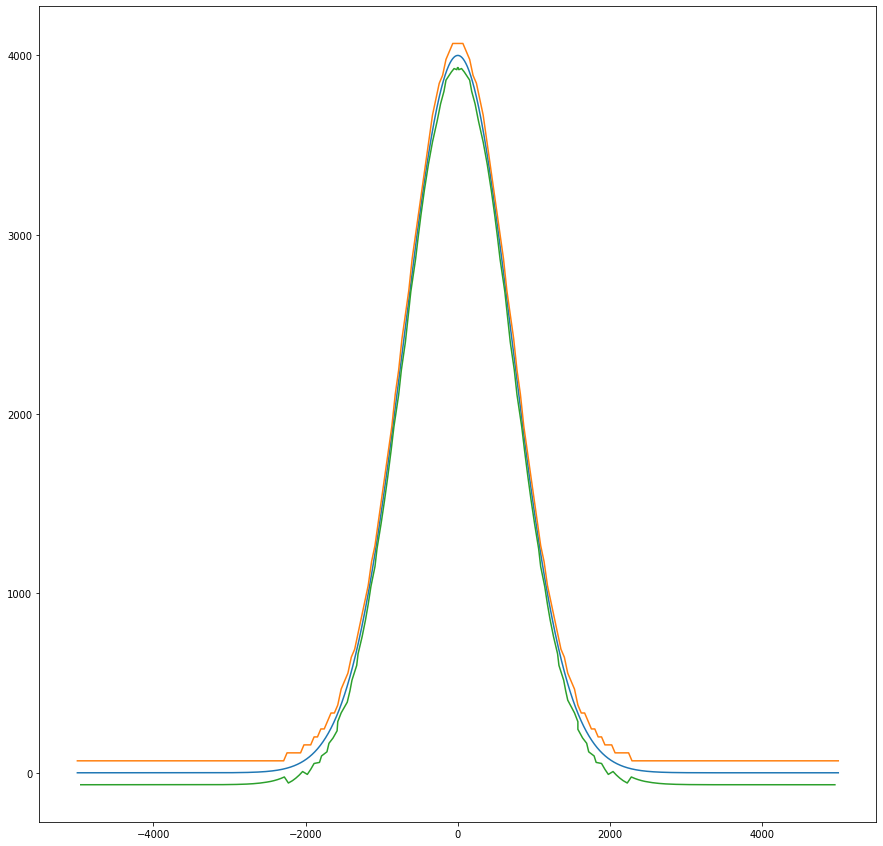

In [14]:
Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu,longueur_grille_x)

Coef_interpolation=cuda.mem_alloc(Nx*U.nbytes)
Calcul_coefficient_interpolation(Coef_interpolation, Coor_miroir_gpu,dx,dz,x_min,z_min, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))

pp.figure(figsize=(15, 15))
pp.plot(x_surface,z_surface)
pp.plot(x,z_fantome)
cuda.memcpy_dtoh(Coor_miroir, Coor_miroir_gpu)
pp.plot(Coor_miroir[1:-1,0],Coor_miroir[1:-1,1])
pp.show

# Calcul de la propagation et Affichage de la propagation

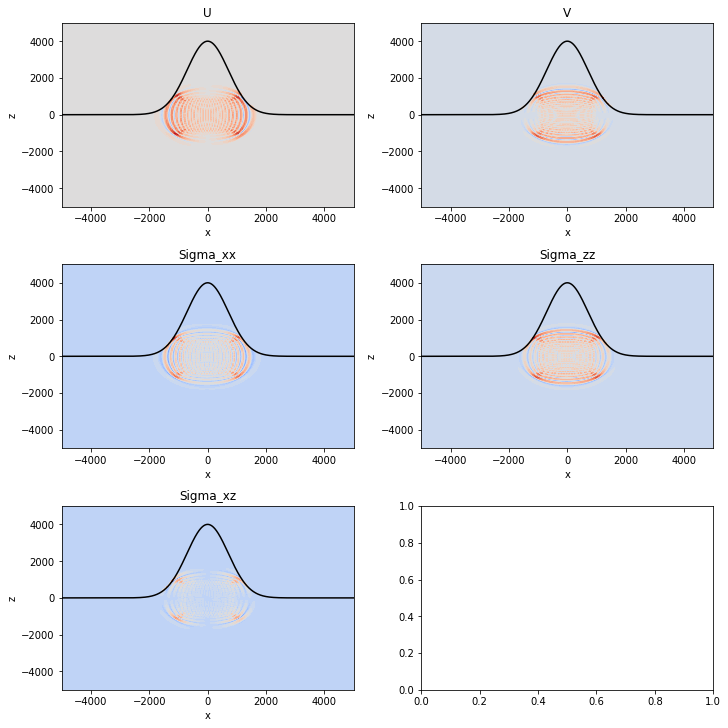

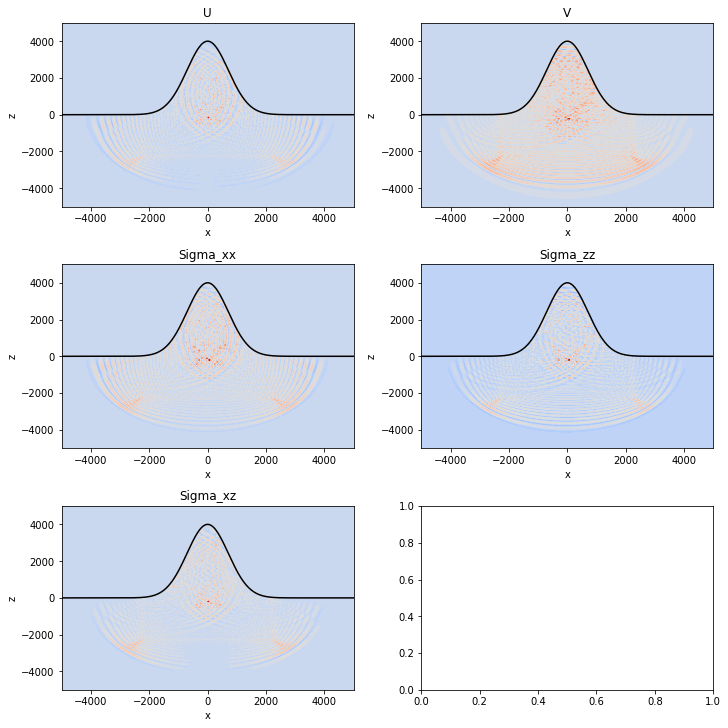

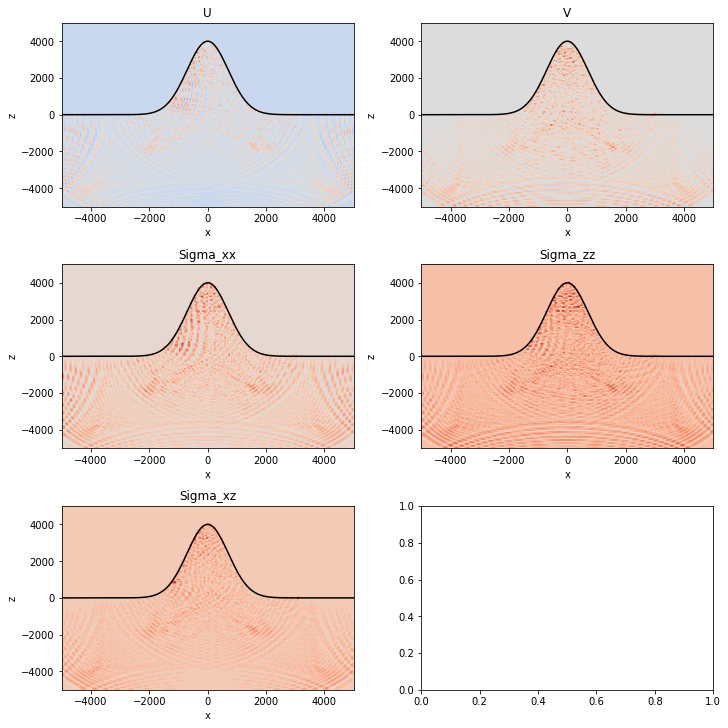

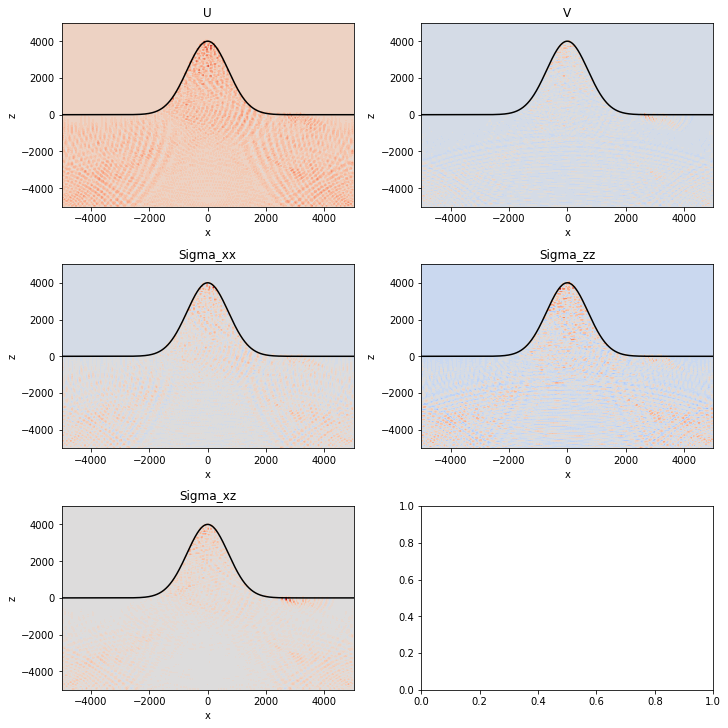

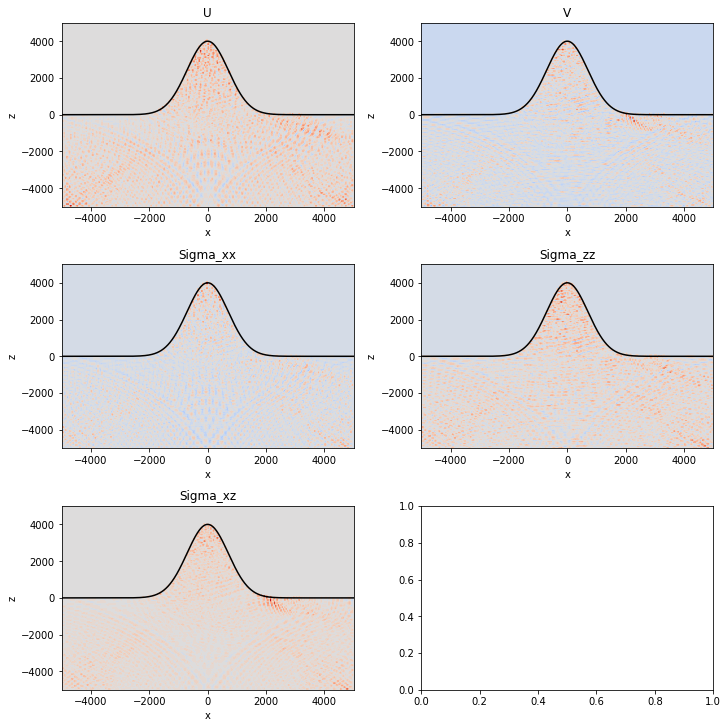

In [15]:
Methode_calcul_mirror = True
trace_type="coolwarm"
nb_iter_aff=100
vecteur_source=[]

# Définition des paramétres d'itération en temps
nt = 0
t = np.float32(0)

source_t=Fonction_Source(t,alpha,t0)
Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu, 
              Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
              longueur_grille_z, source_t, Methode_calcul_mirror)
vecteur_source.append(source_t)
while nt < Nt:
# Itération en temps
    nt += 1
    t += dt
    
    source_t=Fonction_Source(t,alpha,t0)
    Calcul_velocity(U_gpu, U_gpu_cpy, V_gpu, V_gpu_cpy, B_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                    dz, longueur_grille_x, longueur_grille_z, Methode_calcul_mirror)
    
    
    # Calcul des contraintes sur toute la matrice
    Calcul_Stress(U_gpu, V_gpu, L_gpu, M_gpu, coor_source, Sigma_xx_gpu, Sigma_xx_gpu_cpy, Sigma_zz_gpu, 
                  Sigma_zz_gpu_cpy, Sigma_xz_gpu, Sigma_xz_gpu_cpy, dt, dx, dz, longueur_grille_x, 
                  longueur_grille_z, source_t, Methode_calcul_mirror)
    vecteur_source.append(source_t)
    
    # Affichage en python
    if nt % nb_iter_aff == 0:        
        # On importe les résultats Cuda en python
        cuda.memcpy_dtoh(U, U_gpu)
        cuda.memcpy_dtoh(V, V_gpu)
        cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
        cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
        cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)
        
        Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, trace_type, True, x_surface, z_surface)


# Suppression du contexte

In [16]:
contx.pop()

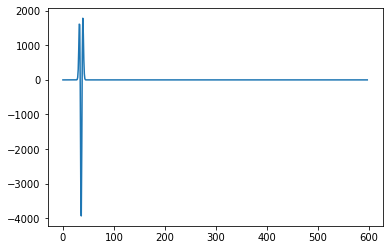

In [17]:
pp.plot(vecteur_source)
